# **Réseaux de neurones pour predire le niveau de langue du locuteur**

Ceci est le script qui implemente les réseaux de neurones que nous avons utilisé dans le cadre du projet final pour le cours de Réseau de Neurones pour l'Oral.
Nous avons donc utilisé des modèles sequentiels lorsqu'on a obtenu des embeddings des enregistrements avec Wav2Vec (script disponible dans le notebook "processing.ipynb") et des embeddings du text correspondant à chaque segment audio obtenus avec BERT (script egalement disponible dans le notebook "processing.ipynb").

In [1]:
### TRÈS IMPORTANT !!!! ###
### SINON CONFLITS ###

!pip install --upgrade --force-reinstall pandas numpy tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [1]:
### IMPORTS ###

#==== Gestion des chemins ====#
import glob

#==== Traitement des données ====#
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

#==== Apprentissage automatique ====#
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#.==== Visualisation ====#
import matplotlib.pyplot as plt

***Définition des chemins globaux pour gestion du Drive***

In [2]:
### Permet de synchroniser les données du notebook à celles du Drive ###
from google.colab import drive

drive.mount('/content/drive')
base_path = "/content/drive"

Mounted at /content/drive


In [3]:
### Permet d'obtenir une variable pouvant être ré-utilisée pour les chemins de sauvegarde/d'importation

global folder
folder = base_path + "/MyDrive/Madalina_et_Kehina"

# **1. Statistiques descriptives**

Nous commencons par visualiser la distribution des données en fonction des classes.

In [ ]:
def data_prep(all_files):

    classes_dict = Counter()
    for file in all_files:
        file_class = file.split("_")[5]
        if file_class != "C2":
          classes_dict[file_class] += 1

    classes_percentages = {k: v / sum(classes_dict.values()) * 100 for k, v in classes_dict.items()}

    return classes_dict, classes_percentages

In [ ]:
def visualise_data(distribution_dict):

    plt.figure(figsize=(10, 6))
    plt.bar(distribution_dict.keys(), distribution_dict.values(), color="lightsteelblue")
    plt.xlabel('Classes')
    plt.ylabel('Pourcentage d\'enregistrements')
    plt.title('Pourcentage d\'enregistrements par classe')
    plt.show()

Pour la distribution des classes AVANT segmentation.

In [ ]:
all_recordings = glob.glob("/content/drive/MyDrive/Madalina_et_Kehina/Fr_for_webmaus/*.mp3")
classes_dict_recordings, classes_percentages_recordings = data_prep(all_recordings)
if "C2" in classes_dict_recordings.keys():
    del classes_dict_recordings["C2"]
if "C2" in classes_percentages_recordings.keys():
    del classes_percentages_recordings["C2"]
print(classes_dict_recordings)
print(classes_percentages_recordings)

Counter({'B1': 319, 'A2': 312, 'A1': 165, 'B2': 58, 'C1': 9})
{'B1': 36.9640787949015, 'A2': 36.152954808806484, 'A1': 19.119351100811123, 'B2': 6.720741599073002, 'C1': 1.0428736964078795}


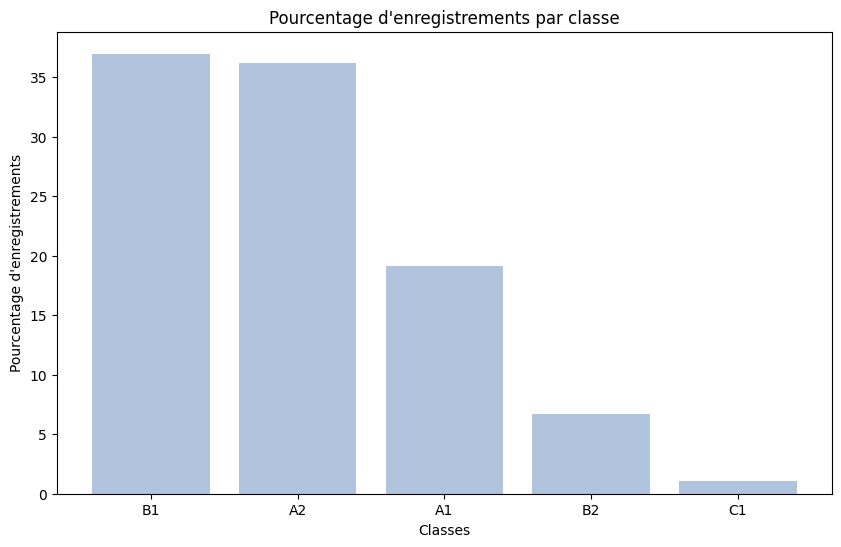

In [ ]:
visualise_data(classes_percentages_recordings)

Pour la distribution des classes APRÈS segmentation.

In [ ]:
all_segments = glob.glob("/content/drive/MyDrive/Madalina_et_Kehina/Segmented_sound_files/*/*.mp3")
classes_dict_segments, classes_percentages_segments = data_prep(all_segments)
if "C2" in classes_dict_segments.keys():
    del classes_dict_segments["C2"]
if "C2" in classes_percentages_segments.keys():
    del classes_percentages_segments["C2"]
print(classes_dict_segments)
print(classes_percentages_segments)

Counter({'B1': 34093, 'A2': 21536, 'B2': 7030, 'A1': 6031, 'C1': 895})
{'A2': 30.94919882158511, 'B2': 10.1027520298915, 'B1': 48.99475461665589, 'A1': 8.667097794064812, 'C1': 1.2861967378026873}


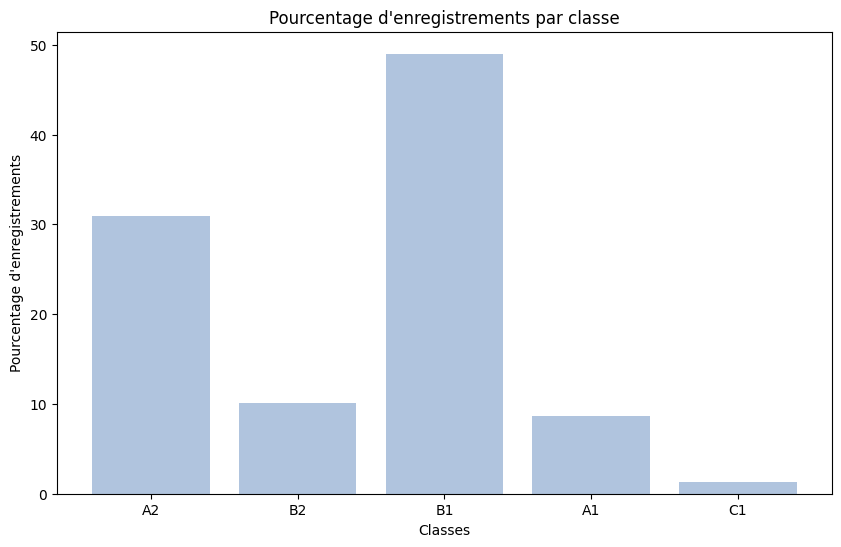

In [ ]:
visualise_data(classes_percentages_segments)

Pour visualiser la répartition des classes dans les ensembles de train et de test.

In [ ]:
df_train = pd.read_pickle("/content/drive/MyDrive/Madalina_et_Kehina/train_df.pkl")
df_test = pd.read_pickle("/content/drive/MyDrive/Madalina_et_Kehina/test_df.pkl")

train_recordings = df_train["filepath"].tolist()
test_recordings = df_test["filepath"].tolist()

classes_dict_train, percentages_dict_train = data_prep(train_recordings)
classes_dict_test, percentages_dict_test = data_prep(test_recordings)
print(classes_dict_train, percentages_dict_train)
print(classes_dict_test, percentages_dict_test)

Counter({'B1': 30615, 'A2': 18827, 'B2': 6549, 'A1': 4618, 'C1': 662}) {'A2': 30.72742406685055, 'B1': 49.96654208353055, 'B2': 10.688580241876254, 'A1': 7.537007719802189, 'C1': 1.0804458879404613}
Counter({'B1': 3478, 'A2': 2709, 'A1': 1413, 'B2': 481, 'C1': 233}) {'A2': 32.58359393793601, 'B2': 5.785422179456338, 'B1': 41.83305268222276, 'A1': 16.99542939619918, 'C1': 2.802501804185711}


In [ ]:
def compare_class_distribution(distribution_dict_train, distribution_dict_test):
    """ Distributions du train et du test en pourcentage. """

    x = np.arange(len(distribution_dict_train))
    width = 0.4
    plt.figure(figsize=(7, 5))
    train_bars = plt.bar(x - 0.2, distribution_dict_train.values(), width, label="Ensemble de train", color="lightsteelblue")
    test_bars = plt.bar(x + 0.2, distribution_dict_test.values(), width, label="Ensemble de test", color="darkseagreen")

    for bar in train_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 2)}', ha="center", va="bottom")

    for bar in test_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 2)}', ha="center", va="bottom")

    plt.xticks(x, distribution_dict_train.keys(), rotation=45)
    plt.xlabel("Classes")
    plt.ylabel("Pourcentage de documents par classe")
    plt.legend()
    plt.show()

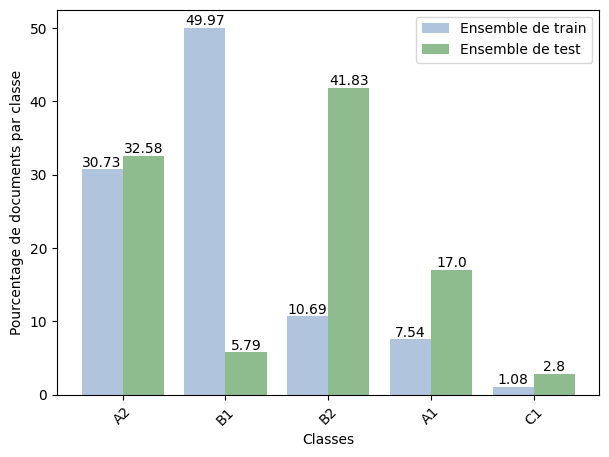

In [ ]:
compare_class_distribution(percentages_dict_train, percentages_dict_test)

Pour voir si l'âge semble moins/plus varier dans une classe en particulier.

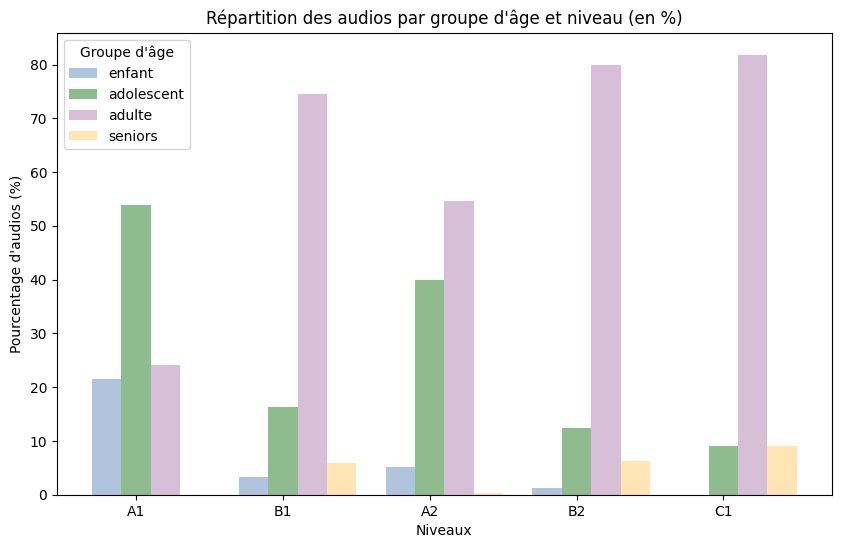

In [ ]:
def age_link(df):

    dict_age = defaultdict(list)
    for idx, row in df.iterrows():
        age = row["Age"]
        level = row["Level"]
        if level == "C2":
            continue
        dict_age[level].append(age)

    return dict_age

def count_age_level(dict_age):

    dict_age_level = {}

    for level, ages in dict_age.items():
        counts = Counter(ages)
        dict_age_level[level] = counts

    return dict_age_level

def plot_age_level(dict_age_level):

    categories = ['enfant', 'adolescent', 'adulte', 'seniors']
    categories_color = ["lightsteelblue", "darkseagreen", "thistle", "moccasin"]
    niveaux = list(dict_age_level.keys())

    total_per_niveau = {niveau: sum(dict_age_level[niveau].values()) for niveau in niveaux}

    percentages = {
        cat: [(dict_age_level[niveau].get(cat, 0) / total_per_niveau[niveau]) * 100 for niveau in niveaux]
        for cat in categories
    }

    x = np.arange(len(niveaux))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, cat, i_col, cat_col in zip(range(len(categories)), categories, range(len(categories_color)), categories_color):
        ax.bar(x + i * width, percentages[cat], width, label=cat, color=cat_col)

    ax.set_xlabel("Niveaux")
    ax.set_ylabel("Pourcentage d'audios (%)")
    ax.set_title("Répartition des audios par groupe d'âge et niveau (en %)")
    ax.set_xticks(x + width)
    ax.set_xticklabels(niveaux)
    ax.legend(title="Groupe d'âge")
    plt.show()

df = pd.read_csv("/content/drive/MyDrive/Madalina_et_Kehina/Fr.csv")
dict_age = age_link(df)
dict_age_level = count_age_level(dict_age)
plot_age_level(dict_age_level)

# **2. Sequential models**

In [ ]:
# La fonction pour recuperer les données après avoir obtenu les embeddings avec Wav2Vec pour les fichiers son ou BERT pour la transcription

def get_data_with_embeddings(path_to_train_pickle_df, path_to_test_pickle_df):
  train_df = pd.read_pickle(path_to_train_pickle_df)
  test_df = pd.read_pickle(path_to_test_pickle_df)

  if 'embeddings' in train_df.columns:
    x_train = np.array(train_df['embeddings'].tolist())
    x_test = np.array(test_df['embeddings'].tolist())
  elif 'average_vector' in train_df.columns:
    x_train = np.array(train_df['average_vector'].tolist())
    x_test = np.array(test_df['average_vector'].tolist())

  if 'level' in train_df.columns:
    dico = {"A1":0, "A2":1, "B1":2, "B2":3, "C1":4}
    train_df['category_id'] = train_df['level'].apply(lambda x: dico[x])
    test_df['category_id'] = test_df['level'].apply(lambda x: dico[x])

  if 'category_id' in train_df.columns:
    y_train = to_categorical(train_df['category_id'].tolist())
    y_test = to_categorical(test_df['category_id'].tolist())

  return x_train, y_train, x_test, y_test

In [ ]:
# Les fonctions pour les architectures que nous avons testées.

def create_model_1(input_shape):
    model = Sequential()
    model.add(Dense(768, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(200, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

def create_model_2(input_shape):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(200, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def create_model_3(input_shape):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

architectures = [create_model_1, create_model_2, create_model_3]

In [ ]:
# La fonction qui lance les modeles et les evalue
def get_results(architectures, x_train, y_train, x_test, y_test, batch_size):
  results = []
  for create_model in architectures:
    model = create_model((x_train.shape[1],))
    summary = model.fit(x_train, y_train, epochs=50, batch_size=batch_size, verbose=1, validation_split=0.2)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    results.append((model, summary, loss, accuracy))
  return results

In [ ]:
def print_results(results):
  for i, (model, summary, loss, accuracy) in enumerate(results):

    print(f"Architecture {i+1}")
    print(f"Training Accuracy: {summary.history['accuracy'][-1]}")
    print(f"Validation Accuracy: {summary.history['val_accuracy'][-1]}")
    print(f"Training Loss: {summary.history['loss'][-1]}")
    print(f"Validation Loss: {summary.history['val_loss'][-1]}")
    print(f"Test Accuracy: {accuracy}")
    print(f"Test Loss: {loss}")
    plt.plot(summary.history['accuracy'],'red',marker = 'o')
    plt.plot(summary.history['val_accuracy'],'blue',marker = 'o')
    plt.title('Courbe d\'apprentissage')
    plt.ylabel('epochs')
    plt.legend(['acc','val_acc'],loc='upper left')
    plt.show()
    plt.close()

## **2.1 Predictions avec les embeddings Wav2Vec**

### Résultats pour les trois structures de DNN avec un batch size de 50.

In [ ]:
# Obtenir les données
train_pickle_dataframe = folder + "/Pickle_dataframes/train_df_with_embeddings.pkl"
test_pickle_dataframe = folder + "/Pickle_dataframes/test_df_with_embeddings.pkl"

x_train, y_train, x_test, y_test = get_data_with_embeddings(train_pickle_dataframe, test_pickle_dataframe)

In [ ]:
# Tester avec un batch size de 50
results = get_results(architectures, x_train, y_train, x_test, y_test, 50)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.3689 - loss: 2.6774 - val_accuracy: 0.4278 - val_loss: 1.9729
Epoch 2/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.5093 - loss: 1.7427 - val_accuracy: 0.5097 - val_loss: 1.5216
Epoch 3/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.5300 - loss: 1.4293 - val_accuracy: 0.4615 - val_loss: 1.5653
Epoch 4/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5384 - loss: 1.2832 - val_accuracy: 0.4753 - val_loss: 1.4354
Epoch 5/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5396 - loss: 1.2178 - val_accuracy: 0.2491 - val_loss: 1.9446
Epoch 6/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5413 - loss: 1.1919 - val_accuracy: 0.5207 - val_loss: 1.2441
Epoch 7/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - accuracy: 0.5516 - loss: 1.1758 - val_accuracy: 0.5207 - val_loss: 1.2668
Epoch 8/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.5528 - loss: 1.1602 - 

Architecture 1
Training Accuracy: 0.5644925236701965
Validation Accuracy: 0.44834771752357483
Training Loss: 1.1000460386276245
Validation Loss: 1.6421232223510742
Test Accuracy: 0.5175168514251709
Test Loss: 1.5641698837280273
Architecture 2
Training Accuracy: 0.5690823197364807
Validation Accuracy: 0.4938969910144806
Training Loss: 1.0801560878753662
Validation Loss: 1.5271360874176025
Test Accuracy: 0.5750012993812561
Test Loss: 1.659883737564087
Architecture 3
Training Accuracy: 0.4560498297214508
Validation Accuracy: 0.4574774205684662
Training Loss: 1.238171935081482
Validation Loss: 1.235199213027954
Test Accuracy: 0.578708291053772
Test Loss: 1.1541721820831299


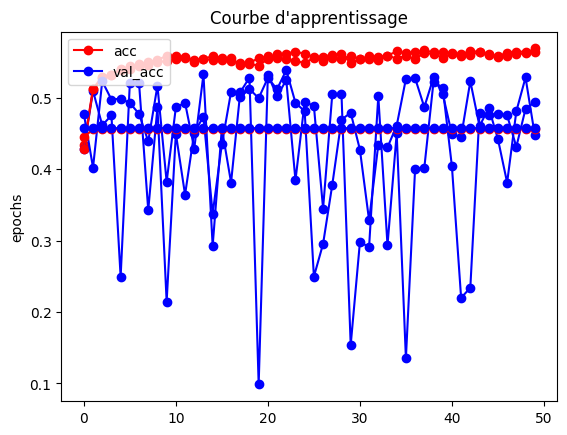

In [ ]:
print_results(results)

### Résultats pour les trois structures de DNN avec un batch size de 128.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.3191 - loss: 2.9063 - val_accuracy: 0.4555 - val_loss: 2.0734
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.4925 - loss: 1.9866 - val_accuracy: 0.4975 - val_loss: 1.7687
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5278 - loss: 1.6555 - val_accuracy: 0.5197 - val_loss: 1.5612
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.5491 - loss: 1.4418 - val_accuracy: 0.3831 - val_loss: 1.6896
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.5535 - loss: 1.3217 - val_accuracy: 0.4848 - val_loss: 1.4658
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.5708 - loss: 1.2367 - val_accuracy: 0.5050 - val_loss: 1.3592
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.5800 - loss: 1.1836 - val_accuracy: 0.4663 - val_loss: 1.8394
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.5814 - loss: 1.1551 - 

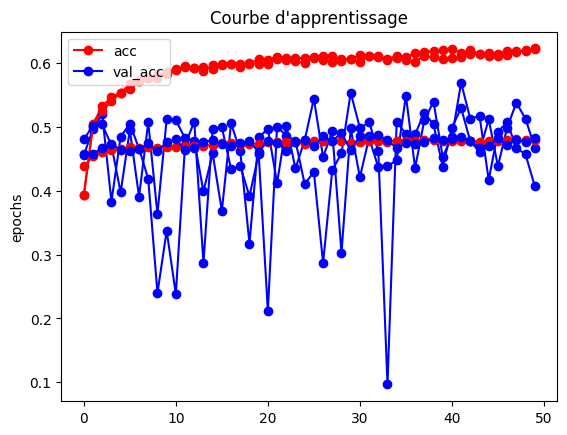

In [ ]:
# Tester avec un batch size de 128
results = get_results(architectures, x_train, y_train, x_test, y_test, 128)
print_results(results)

### Résultats pour les trois structures de DNN avec un batch size de 256.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.2990 - loss: 3.1321 - val_accuracy: 0.4886 - val_loss: 2.2313
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4731 - loss: 2.2278 - val_accuracy: 0.5055 - val_loss: 1.9576
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.5178 - loss: 1.8962 - val_accuracy: 0.4964 - val_loss: 1.7864
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5349 - loss: 1.6766 - val_accuracy: 0.5193 - val_loss: 1.6446
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5525 - loss: 1.5204 - val_accuracy: 0.4542 - val_loss: 1.6479
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.5692 - loss: 1.3907 - val_accuracy: 0.5193 - val_loss: 1.4300
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5730 - loss: 1.2979 - val_accuracy: 0.4838 - val_loss: 1.5174
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5839 - loss: 1.2355 - val_

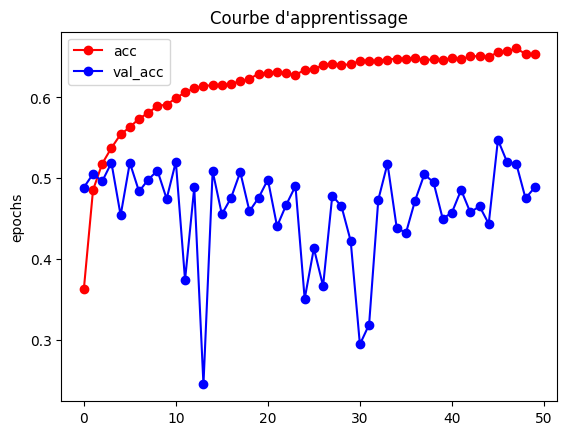

Architecture 2
Training Accuracy: 0.6527153849601746
Validation Accuracy: 0.4842711091041565
Training Loss: 0.9392381310462952
Validation Loss: 1.2605719566345215
Test Accuracy: 0.2576097846031189
Test Loss: 1.8459714651107788


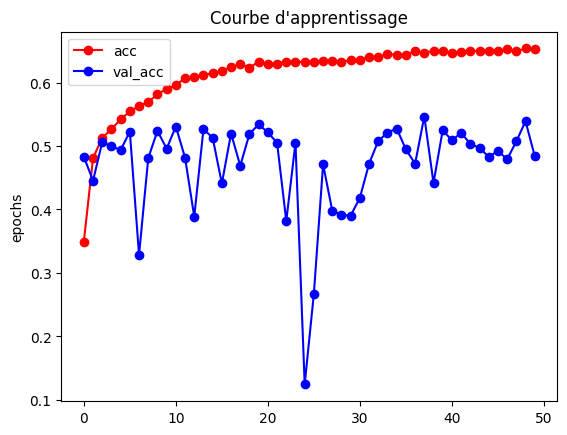

Architecture 3
Training Accuracy: 0.4857965111732483
Validation Accuracy: 0.4824848771095276
Training Loss: 1.180823802947998
Validation Loss: 1.1877187490463257
Test Accuracy: 0.5800135731697083
Test Loss: 1.1277152299880981


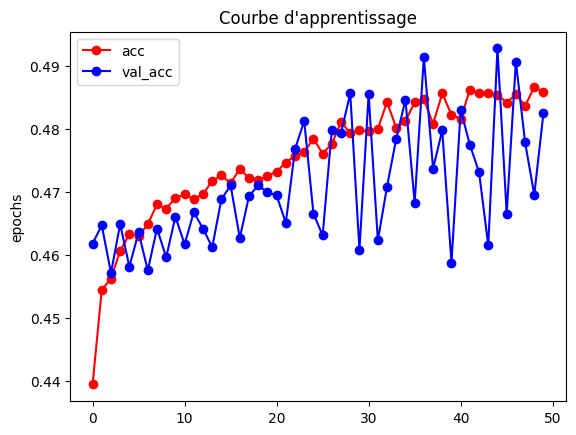

In [ ]:
# Tester avec un batch size de 256
results = get_results(architectures, x_train, y_train, x_test, y_test, 256)
print_results(results)

## **2.2 Predictions avec les embeddings Wav2Vec - données d'entraînement bruitées**

In [ ]:
# Obtenir les données
train_pickle_dataframe = folder + "/Pickle_dataframes/train_df_with_embeddings_augmented.pkl"
test_pickle_dataframe = folder + "/Pickle_dataframes/test_df_with_embeddings.pkl"

x_train, y_train, x_test, y_test = get_data_with_embeddings(train_pickle_dataframe, test_pickle_dataframe)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.3522 - loss: 2.6786 - val_accuracy: 0.4686 - val_loss: 1.8374
Epoch 2/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.4926 - loss: 1.7439 - val_accuracy: 0.5089 - val_loss: 1.5090
Epoch 3/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.5146 - loss: 1.4372 - val_accuracy: 0.4216 - val_loss: 1.5656
Epoch 4/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5252 - loss: 1.2933 - val_accuracy: 0.4427 - val_loss: 1.3920
Epoch 5/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.5245 - loss: 1.2380 - val_accuracy: 0.4849 - val_loss: 1.2915
Epoch 6/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.5276 - loss: 1.2147 - val_accuracy: 0.4140 - val_loss: 1.3600
Epoch 7/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.5292 - loss: 1.1975 - val_accuracy: 0.4537 - val_loss: 1.3414
Epoch 8/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.5307 - loss: 1.1828 - 

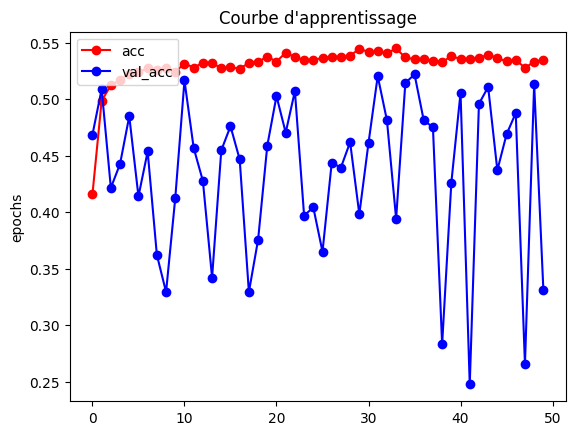

Architecture 2
Training Accuracy: 0.5325129628181458
Validation Accuracy: 0.44348517060279846
Training Loss: 1.1398597955703735
Validation Loss: 1.2939320802688599
Test Accuracy: 0.41852450370788574
Test Loss: 1.3510740995407104


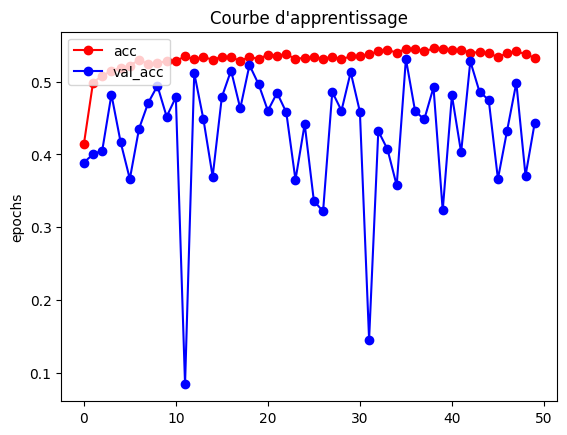

Architecture 3
Training Accuracy: 0.4542139172554016
Validation Accuracy: 0.46482089161872864
Training Loss: 1.240154504776001
Validation Loss: 1.226466417312622
Test Accuracy: 0.578708291053772
Test Loss: 1.150539755821228


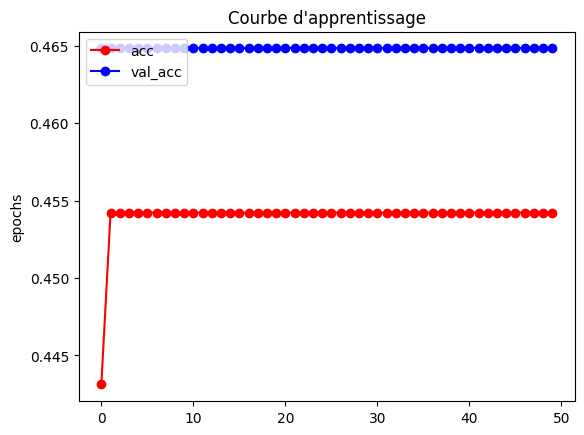

In [ ]:
# Tester avec un batch size de 50
results = get_results(architectures, x_train, y_train, x_test, y_test, 50)
print_results(results)

Epoch 1/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.3118 - loss: 2.9341 - val_accuracy: 0.4916 - val_loss: 2.0392
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.4749 - loss: 2.0213 - val_accuracy: 0.5059 - val_loss: 1.7560
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.5098 - loss: 1.6866 - val_accuracy: 0.5135 - val_loss: 1.5705
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.5316 - loss: 1.4776 - val_accuracy: 0.4863 - val_loss: 1.4601
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.5418 - loss: 1.3438 - val_accuracy: 0.3213 - val_loss: 1.7054
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.5422 - loss: 1.2649 - val_accuracy: 0.4827 - val_loss: 1.3577
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5600 - loss: 1.2021 - val_accuracy: 0.3497 - val_loss: 1.4829
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5655 - loss: 1.1640 - 

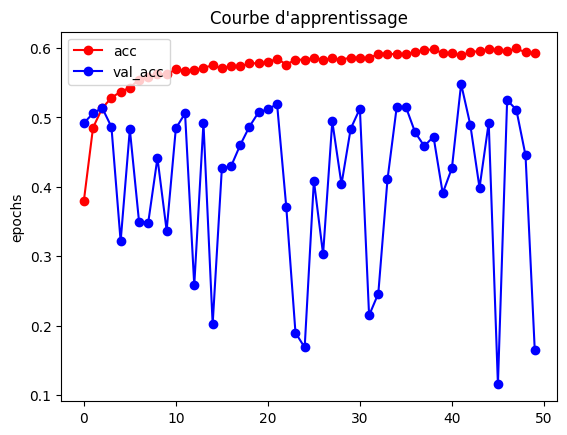

Architecture 2
Training Accuracy: 0.5992755889892578
Validation Accuracy: 0.3479210138320923
Training Loss: 1.0364067554473877
Validation Loss: 1.8328590393066406
Test Accuracy: 0.2873179018497467
Test Loss: 2.1249396800994873


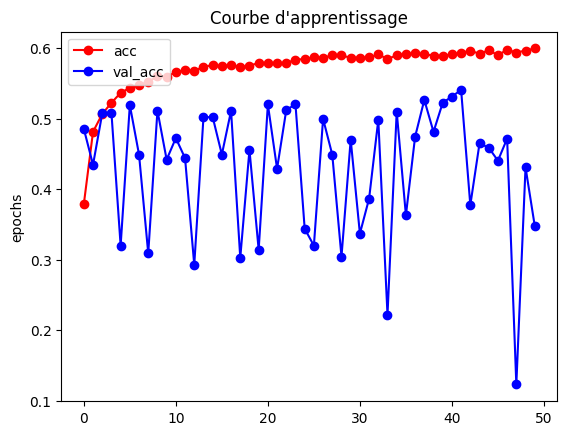

Architecture 3
Training Accuracy: 0.4542139172554016
Validation Accuracy: 0.46482089161872864
Training Loss: 1.2191084623336792
Validation Loss: 1.2073800563812256
Test Accuracy: 0.578708291053772
Test Loss: 1.1452019214630127


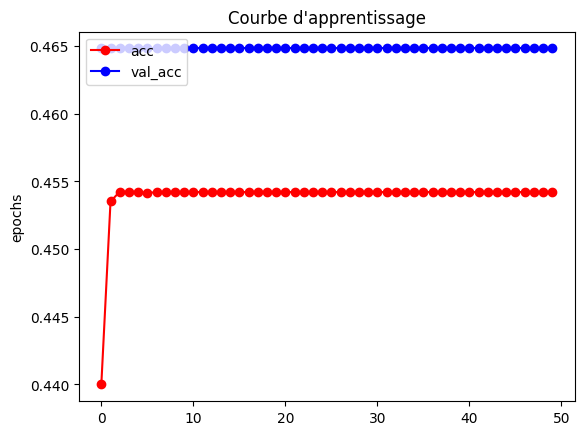

In [ ]:
# Tester avec un batch size de 128
results = get_results(architectures, x_train, y_train, x_test, y_test, 128)
print_results(results)

In [ ]:
# Tester avec un batch size de 256
results = get_results(architectures, x_train, y_train, x_test, y_test, 256)
print_results(results)

## **2.3 Predictions avec les embeddings BERT des transcriptions obtenues avec Whisper et alignées avec WebMaus**

In [ ]:
# Obtenir les données
train_pickle_dataframe = folder + "/Pickle_dataframes/train_aligned_transcript_df.pkl"
test_pickle_dataframe = folder + "/Pickle_dataframes/test_aligned_transcript_df.pkl"

x_train, y_train, x_test, y_test = get_data_with_embeddings(train_pickle_dataframe, test_pickle_dataframe)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.3349 - loss: 2.8271 - val_accuracy: 0.4951 - val_loss: 1.8693
Epoch 2/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4359 - loss: 1.8011 - val_accuracy: 0.5001 - val_loss: 1.4749
Epoch 3/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.4469 - loss: 1.4529 - val_accuracy: 0.4932 - val_loss: 1.3274
Epoch 4/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.4450 - loss: 1.3300 - val_accuracy: 0.5039 - val_loss: 1.2686
Epoch 5/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4523 - loss: 1.2834 - val_accuracy: 0.4846 - val_loss: 1.2539
Epoch 6/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.4477 - loss: 1.2675 - val_accuracy: 0.5017 - val_loss: 1.2370
Epoch 7/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4518 - loss: 1.2646 - val_accuracy: 0.5113 - val_loss: 1.2280
Epoch 8/50
807/807 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.4508 - loss: 1.2575 - 

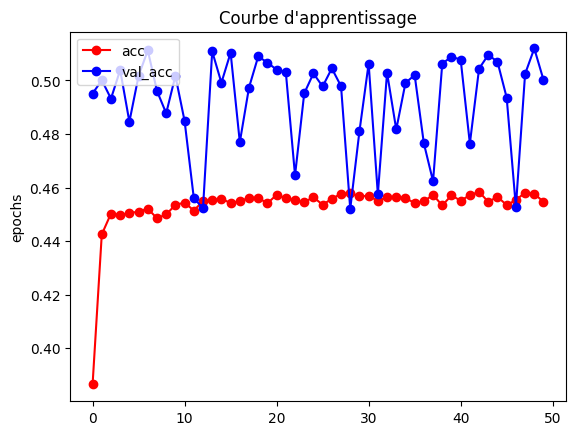

Architecture 2
Training Accuracy: 0.4586796462535858
Validation Accuracy: 0.5069961547851562
Training Loss: 1.2273117303848267
Validation Loss: 1.2044599056243896
Test Accuracy: 0.5657599568367004
Test Loss: 1.132851243019104


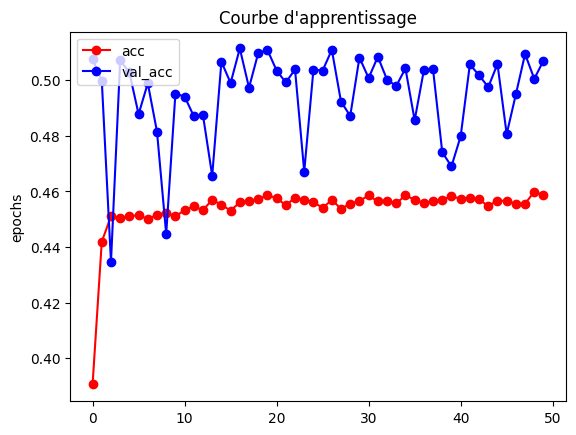

Architecture 3
Training Accuracy: 0.5024933815002441
Validation Accuracy: 0.5074923038482666
Training Loss: 1.1332091093063354
Validation Loss: 1.2131496667861938
Test Accuracy: 0.5650811791419983
Test Loss: 1.1362342834472656


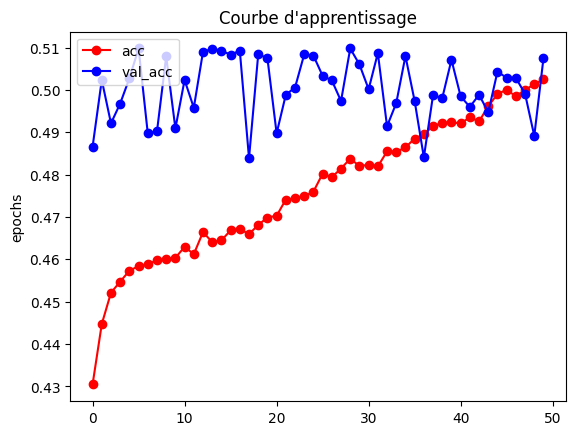

In [ ]:
# Tester avec un batch size de 50
results = get_results(architectures, x_train, y_train, x_test, y_test, 50)
print_results(results)

Epoch 1/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.2774 - loss: 3.0643 - val_accuracy: 0.4897 - val_loss: 2.1538
Epoch 2/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.4253 - loss: 2.1157 - val_accuracy: 0.5034 - val_loss: 1.7539
Epoch 3/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.4376 - loss: 1.7369 - val_accuracy: 0.5079 - val_loss: 1.5145
Epoch 4/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.4483 - loss: 1.5179 - val_accuracy: 0.5057 - val_loss: 1.3852
Epoch 5/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.4538 - loss: 1.3959 - val_accuracy: 0.4739 - val_loss: 1.3362
Epoch 6/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.4513 - loss: 1.3329 - val_accuracy: 0.4797 - val_loss: 1.2941
Epoch 7/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.4570 - loss: 1.2982 - val_accuracy: 0.5009 - val_loss: 1.2585
Epoch 8/50
315/315 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.4545 - loss: 1.2809 - 

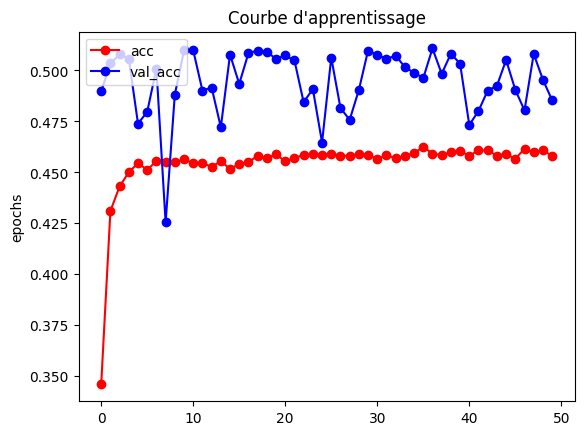

Architecture 2
Training Accuracy: 0.461557537317276
Validation Accuracy: 0.5066984295845032
Training Loss: 1.2190771102905273
Validation Loss: 1.2112234830856323
Test Accuracy: 0.5742181539535522
Test Loss: 1.130317211151123


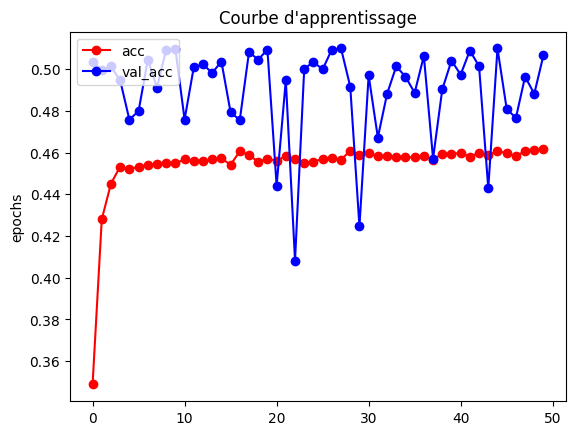

Architecture 3
Training Accuracy: 0.5189669132232666
Validation Accuracy: 0.4756375849246979
Training Loss: 1.087680697441101
Validation Loss: 1.2799698114395142
Test Accuracy: 0.5275413990020752
Test Loss: 1.1986943483352661


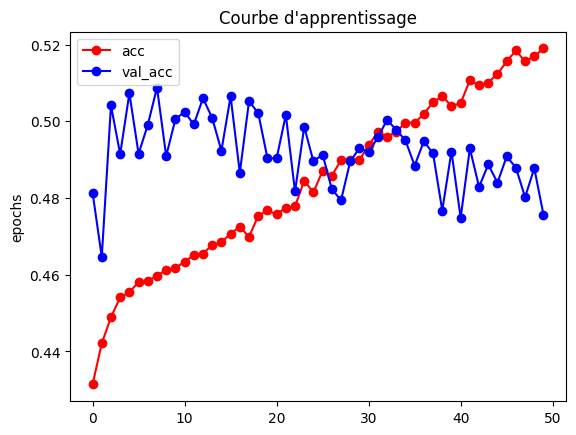

In [ ]:
# Tester avec un batch size de 128
results = get_results(architectures, x_train, y_train, x_test, y_test, 128)
print_results(results)

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.2519 - loss: 3.1755 - val_accuracy: 0.5050 - val_loss: 2.3490
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4047 - loss: 2.3870 - val_accuracy: 0.5063 - val_loss: 2.0117
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.4282 - loss: 2.0157 - val_accuracy: 0.5072 - val_loss: 1.7676
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.4451 - loss: 1.7691 - val_accuracy: 0.4812 - val_loss: 1.6103
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.4498 - loss: 1.5969 - val_accuracy: 0.5025 - val_loss: 1.4789
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.4546 - loss: 1.4832 - val_accuracy: 0.5080 - val_loss: 1.4002
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.4555 - loss: 1.4074 - val_accuracy: 0.4991 - val_loss: 1.3426
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.4569 - loss: 1.3582 - val_a

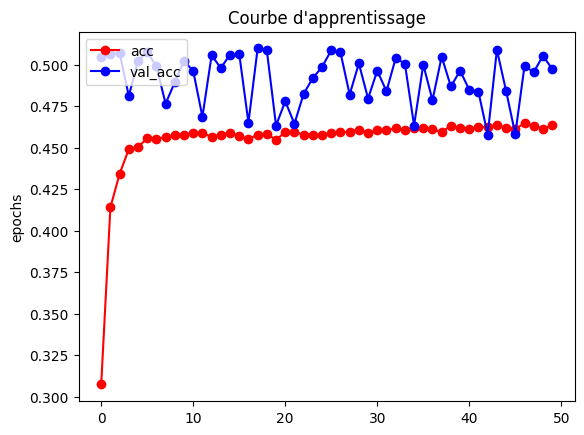

Architecture 2
Training Accuracy: 0.461780846118927
Validation Accuracy: 0.4904237389564514
Training Loss: 1.217360258102417
Validation Loss: 1.2354450225830078
Test Accuracy: 0.5440400838851929
Test Loss: 1.167046070098877


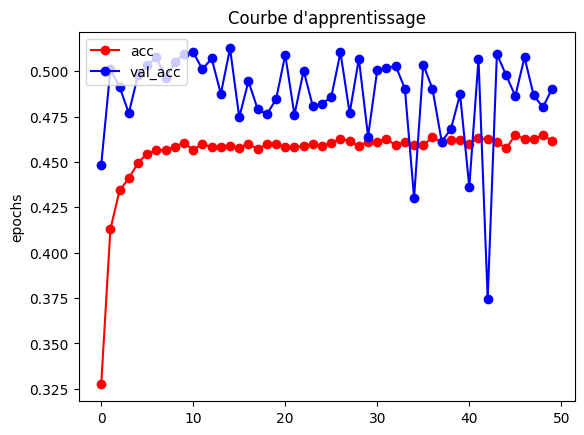

Architecture 3
Training Accuracy: 0.5260872840881348
Validation Accuracy: 0.4724620282649994
Training Loss: 1.0741846561431885
Validation Loss: 1.28336501121521
Test Accuracy: 0.5301519632339478
Test Loss: 1.1904956102371216


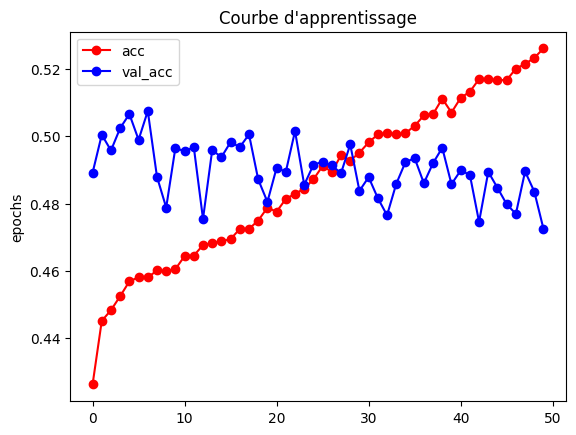

In [ ]:
# Tester avec un batch size de 256
results = get_results(architectures, x_train, y_train, x_test, y_test, 256)
print_results(results)

#**3. Réseau de neurones convolutif**

In [4]:
def get_image(path):
    try:
        img = load_img(path, color_mode='grayscale')
        img_array = img_to_array(img)
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None
    return img_array

In [10]:
def get_x_y(df):
  x, y = [], []
  dico = {"A1":0, "A2":1, "B1":2, "B2":3, "C1":4}
  spectrograms = df['spectrogram_path'].tolist()
  for path in spectrograms:
    img_array = get_image(path)
    x.append(img_array)

  x = np.array(x)
  x = x.astype('float32') / 255.0

  y = df['category'].tolist()
  y = to_categorical([dico[x] for x in y])
  return x, y

In [6]:
def get_data_with_spectrograms(path_to_train_pickle_df, path_to_test_pickle_df):
  train_df = pd.read_pickle(path_to_train_pickle_df)
  test_df = pd.read_pickle(path_to_test_pickle_df)

  x_train, y_train = get_x_y(train_df)
  x_test, y_test = get_x_y(test_df)

  return x_train, y_train, x_test, y_test


In [7]:
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [8]:
def get_cnn_results(x_train, y_train, x_test, y_test, batch_size, input_shape):
  results = []
  model = create_cnn_model(input_shape)
  summary = model.fit(x_train, y_train, epochs=10, batch_size=batch_size, verbose=1, validation_split=0.2)
  loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
  results.append((model, summary, loss, accuracy))
  return results

## **3.1 Predictions avec des spectrogrammes de dimensions 50 x 50**

In [ ]:
# Obtenir les données
train_pickle_dataframe = folder + "/Pickle_dataframes/train_df_with_spectrograms.pkl"
test_pickle_dataframe = folder + "/Pickle_dataframes/test_df_with_spectrograms.pkl"

x_train, y_train, x_test, y_test = get_data_with_spectrograms(train_pickle_dataframe, test_pickle_dataframe)

In [ ]:
results = get_cnn_results(x_train, y_train, x_test, y_test, batch_size=50, input_shape=(50, 50, 1))
print_results(results)

In [ ]:
results = get_cnn_results(x_train, y_train, x_test, y_test, batch_size=128, input_shape=(50, 50, 1))
print_results(results)

In [ ]:
results = get_cnn_results(x_train, y_train, x_test, y_test, batch_size=256, input_shape=(50, 50, 1))
print_results(results)

## **3.2 Predictions avec des spectrogrammes de dimensions 128 x 128**

In [ ]:
# Obtenir les données
train_pickle_dataframe = folder + "Pickle_dataframes/train_df_with_spectrograms_128.pkl"
test_pickle_dataframe = folder + "Pickle_dataframes/test_df_with_spectrograms_128.pkl"

x_train, y_train, x_test, y_test = get_data_with_spectrograms(train_pickle_dataframe, test_pickle_dataframe)

In [ ]:
# Un seul test à cause du temps (celui-ci va durer environ 65 minutes)
results = get_cnn_results(x_train, y_train, x_test, y_test, batch_size=50, input_shape=(128, 128, 1))
print_results(results)